In [70]:
import sys

sys.path.append("..")

import time
import numpy as np
import pandas as pd

import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import eda.util as utils

from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from keras import layers, Sequential, callbacks
from keras.regularizers import l2

import matplotlib.pyplot as plt

from project.config import DATA_FOLDER, SUBSET
from project.utils.fma import load_tracks, load_handcrafted
from project.utils.nn import plot_history


In [71]:
import pandas as pd
import os
import ast

import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np

In [72]:
tracks = utils.load('/fma_metadata/tracks.csv')
features = utils.load('/fma_metadata/features.csv')


In [73]:
subset = tracks['set', 'subset'] <= SUBSET
#subset = tracks.index[tracks['set', 'subset'] <= 'medium']
train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

y_train = tracks.loc[subset & train, ("track", "genre_top")]
y_val = tracks.loc[subset & val, ("track", "genre_top")]
y_test = tracks.loc[subset & test, ("track", "genre_top")]

X_train = features.loc[subset & train]
X_val = features.loc[subset & val]
X_test = features.loc[subset & test]

In [74]:
# redefine typer for genres column
y_train = y_train.astype(
    pd.CategoricalDtype(
        categories=[
            "Electronic",
            "Experimental",
            "Folk",
            "Hip-Hop",
            "Instrumental",
            "International",
            "Pop",
            "Rock",
        ]
    )
)

In [75]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6400, 518), (6400,), (800, 518), (800,), (800, 518), (800,))

In [76]:
counts = y_train.value_counts()
classes = list(y_train.unique())
n_classes = len(counts)
counts

Electronic       800
Experimental     800
Folk             800
Hip-Hop          800
Instrumental     800
International    800
Pop              800
Rock             800
Name: (track, genre_top), dtype: int64

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_val = lab_encoder.transform(y_val)
y_test = lab_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, 8)
y_val = tf.keras.utils.to_categorical(y_val, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\arman\anaconda3\envs\tf_3.7\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [78]:
tf.keras.backend.clear_session()

model = Sequential([
    layers.Dense(512, input_shape=(518,), activation="relu", kernel_regularizer=l2(0.02)),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.02)),
    layers.Dense(n_classes, activation="softmax", kernel_regularizer=l2(0.02))
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               265728    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
Total params: 399,112
Trainable params: 399,112
Non-trainable params: 0
_________________________________________________________________


In [79]:
batch_size = 32

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = model.fit( X_train,y_train, batch_size=batch_size, epochs=200, validation_data=(X_val, y_val), callbacks=[early_stop],)

Epoch 1/200
200/200 [==============================] - 2s 5ms/step - loss: 16.8890 - accuracy: 0.4030 - val_loss: 14.6505 - val_accuracy: 0.4750
Epoch 2/200
200/200 [==============================] - 1s 4ms/step - loss: 12.7650 - accuracy: 0.5491 - val_loss: 11.2160 - val_accuracy: 0.5025
Epoch 3/200
200/200 [==============================] - 1s 5ms/step - loss: 9.7101 - accuracy: 0.5969 - val_loss: 8.6092 - val_accuracy: 0.5300
Epoch 4/200
200/200 [==============================] - 1s 5ms/step - loss: 7.4269 - accuracy: 0.6214 - val_loss: 6.6705 - val_accuracy: 0.5288
Epoch 5/200
200/200 [==============================] - 1s 5ms/step - loss: 5.7396 - accuracy: 0.6394 - val_loss: 5.2628 - val_accuracy: 0.5512
Epoch 6/200
200/200 [==============================] - 1s 4ms/step - loss: 4.5126 - accuracy: 0.6445 - val_loss: 4.2533 - val_accuracy: 0.5462
Epoch 7/200
200/200 [==============================] - 1s 4ms/step - loss: 3.6273 - accuracy: 0.6536 - val_loss: 3.4841 - val_accuracy: 0.

..\project\utils\nn.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


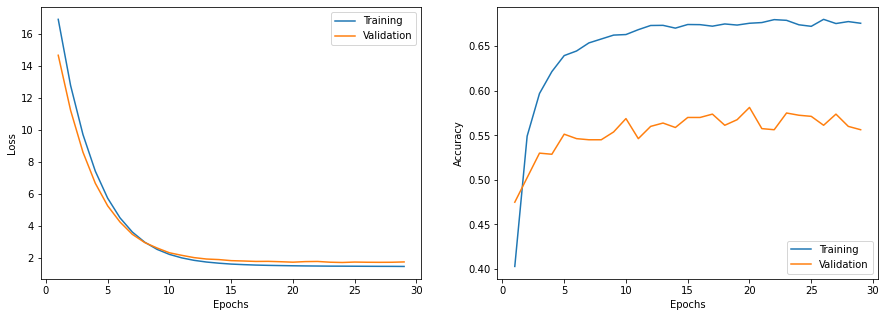

In [80]:
#plot_history(history.history, save=True, filepath="../out/nn_handcrafted.jpg")
plot_history(history.history, save=True, filepath="plot_history.jpg")

In [81]:
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

25/25 [==============================] - 0s 3ms/step - loss: 1.9360 - accuracy: 0.4825


In [82]:
# from keras.callbacks import EarlyStopping

# train_loss = history.history["loss"][early_stop.best_epoch]
# train_acc = history.history["accuracy"][early_stop.best_epoch]
# val_loss = history.history["val_loss"][early_stop.best_epoch]
# val_acc = history.history["val_accuracy"][early_stop.best_epoch]

# print(f"Train\t\t loss: {train_loss}, accuracy: {train_acc}")
# print(f"Validation\t loss: {val_loss}, accuracy: {val_acc}")
# print(f"Test\t\t loss: {loss}, accuracy: {acc}")

In [83]:
y_pred = model.predict(X_test, batch_size=batch_size)

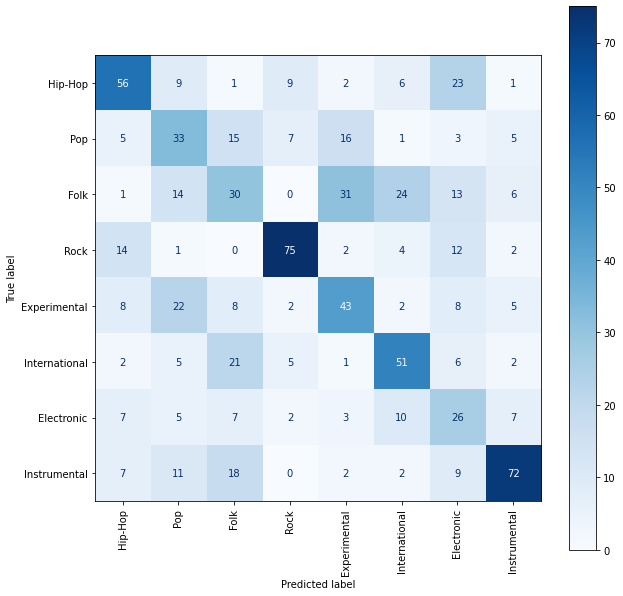

In [84]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)

cm = confusion_matrix(np.argmax(y_pred, 1), np.argmax(y_test, 1))

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, xticks_rotation=90, cmap = 'Blues')

In [85]:
from project.utils.nn import prediction_time
prediction_time(model, input_shape=(518, ), device_name="/cpu:0")
prediction_time(model, input_shape=(518, ), device_name="/gpu:0")

111.03511000037543

# Classical Classifiers

In [86]:
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = [
    ("SVM", SVC()),
    ("KNN", KNeighborsClassifier()),
    ("RF", RandomForestClassifier()),
    ("GNB", GaussianNB()),
]

yy_train = np.argmax(y_train, 1)
yy_test = np.argmax(y_test, 1)

for name, model in models:
    print(name)
    start_time = time.perf_counter()
    model.fit(X_train, yy_train)
    y_pred = model.predict(X_test)
    elapsed = time.perf_counter() - start_time
    report = classification_report(y_pred=y_pred, y_true=yy_test)
    print(elapsed)
    print(report)

SVM
15.85583939999924
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       100
           1       0.36      0.43      0.39       100
           2       0.25      0.25      0.25       100
           3       0.68      0.72      0.70       100
           4       0.41      0.38      0.39       100
           5       0.58      0.41      0.48       100
           6       0.42      0.41      0.41       100
           7       0.59      0.63      0.61       100

    accuracy                           0.48       800
   macro avg       0.48      0.48      0.48       800
weighted avg       0.48      0.48      0.48       800

KNN
0.31914030000189086
              precision    recall  f1-score   support

           0       0.42      0.33      0.37       100
           1       0.40      0.21      0.27       100
           2       0.20      0.31      0.25       100
           3       0.49      0.59      0.53       100
           4       0.29      0.1